# Nötige Libraries installieren
yfinance wird zwingend Version 0.0.43 benötigt, da seit dem Projektstart viele Änderungen an der Library stattgefunden haben und der Code mit neueren Versionen nicht mehr funktioniert.

In [123]:
#pip install yfinance==0.2.43

# Libraries importieren

In [124]:
import yfinance as yf #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns

# Aufbereiten der Daten

In [125]:
# Liste der Tickersymbole der ETFs, die die großen europäischen Indizes abbilden
etfs = {
    "SMI ETF": "CSSMI.SW",
    "DAX ETF": "EXS1.DE",
    "MSCI World Information Technology ETF": "TNOW.MI",
    "ZKB Gold ETF": "ZGLD.SW",
}

# Zeitperiode (letzte 10 Jahre)
start_date = "2014-09-30"
end_date = "2024-09-30"

# Hier werden die spezifischen Datenkategorien ausgewählt, in diesem Falle der Schlusskurs
data_categories = ['Adj Close']

# Daten abrufen und spezifische Kategorien auswählen
data = {}
for name, ticker in etfs.items():
    index_data = yf.download(ticker, start=start_date, end=end_date)
    data[name] = index_data[data_categories]

# Die abgerufenen Daten in ein DataFrame packen
index_data_etfs = pd.DataFrame({name: data[name]['Adj Close'] for name in etfs})

# Leere Daten im Frame auffüllen
index_data_etfs = index_data_etfs.interpolate()

# Performance der ETFs berechnen (prozentuale Veränderung über 10 Jahre)
performance = (index_data_etfs.iloc[-1] / index_data_etfs.iloc[0] - 1) * 100
print("Performance der ETFs über die definierte Zeitdauer Jahre:")
print(performance)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Performance der ETFs über die definierte Zeitdauer Jahre:
SMI ETF                                   84.004959
DAX ETF                                   96.804429
MSCI World Information Technology ETF    559.991513
ZKB Gold ETF                              85.015417
dtype: float64


# Aufbereiten der Daten mit vorgeschlagenen ETFs

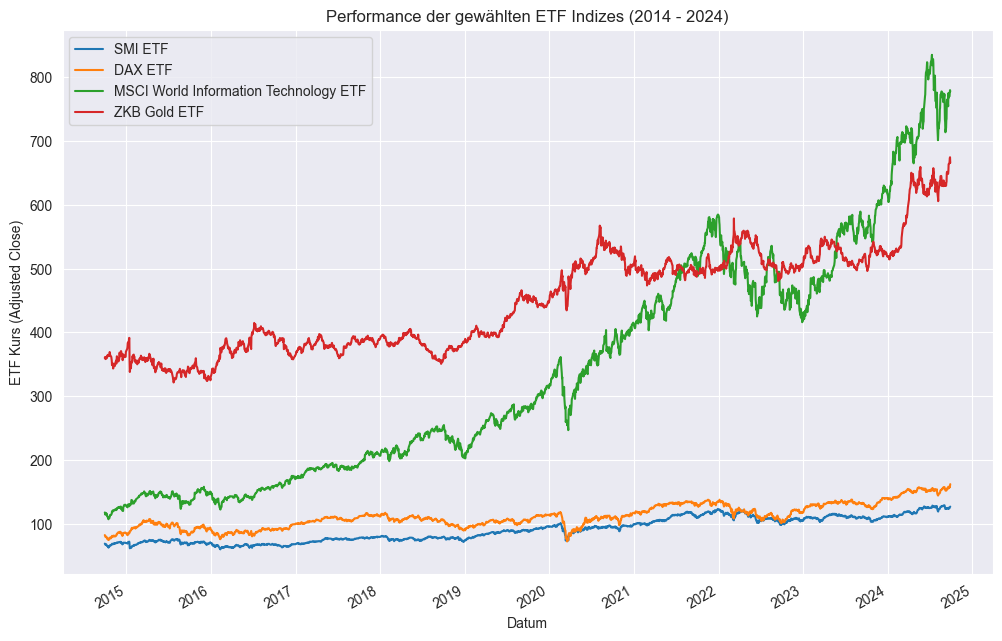

In [137]:
# Plot der ETF-Performance über die letzten 10 Jahre
index_data_etfs.plot(figsize=(12, 8), title='Performance der gewählten ETF Indizes (2014 - 2024)')
plt.xlabel("Datum")
plt.ylabel("ETF Kurs (Adjusted Close)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [127]:
# Schleife durch alle ETFs und zeige die ersten 5 Zeilen für jeden ETF an
for name in etfs:
    print(f"\n{name} - Erste 5 Zeilen:")
    print(index_data_etfs[name].head())


SMI ETF - Erste 5 Zeilen:
Date
2014-09-30    69.030746
2014-10-01    68.542671
2014-10-02    67.453850
2014-10-03    67.694130
2014-10-06    68.054573
Name: SMI ETF, dtype: float64

DAX ETF - Erste 5 Zeilen:
Date
2014-09-30    82.437172
2014-10-01    81.636246
2014-10-02    79.926941
2014-10-03    80.000202
2014-10-06    80.073463
Name: DAX ETF, dtype: float64

MSCI World Information Technology ETF - Erste 5 Zeilen:
Date
2014-09-30    117.849998
2014-10-01    116.760002
2014-10-02    114.599998
2014-10-03    117.150002
2014-10-06    116.949997
Name: MSCI World Information Technology ETF, dtype: float64

ZKB Gold ETF - Erste 5 Zeilen:
Date
2014-09-30    359.970001
2014-10-01    361.559998
2014-10-02    360.380005
2014-10-03    358.299988
2014-10-06    359.859985
Name: ZKB Gold ETF, dtype: float64


# Simple Moving Averages

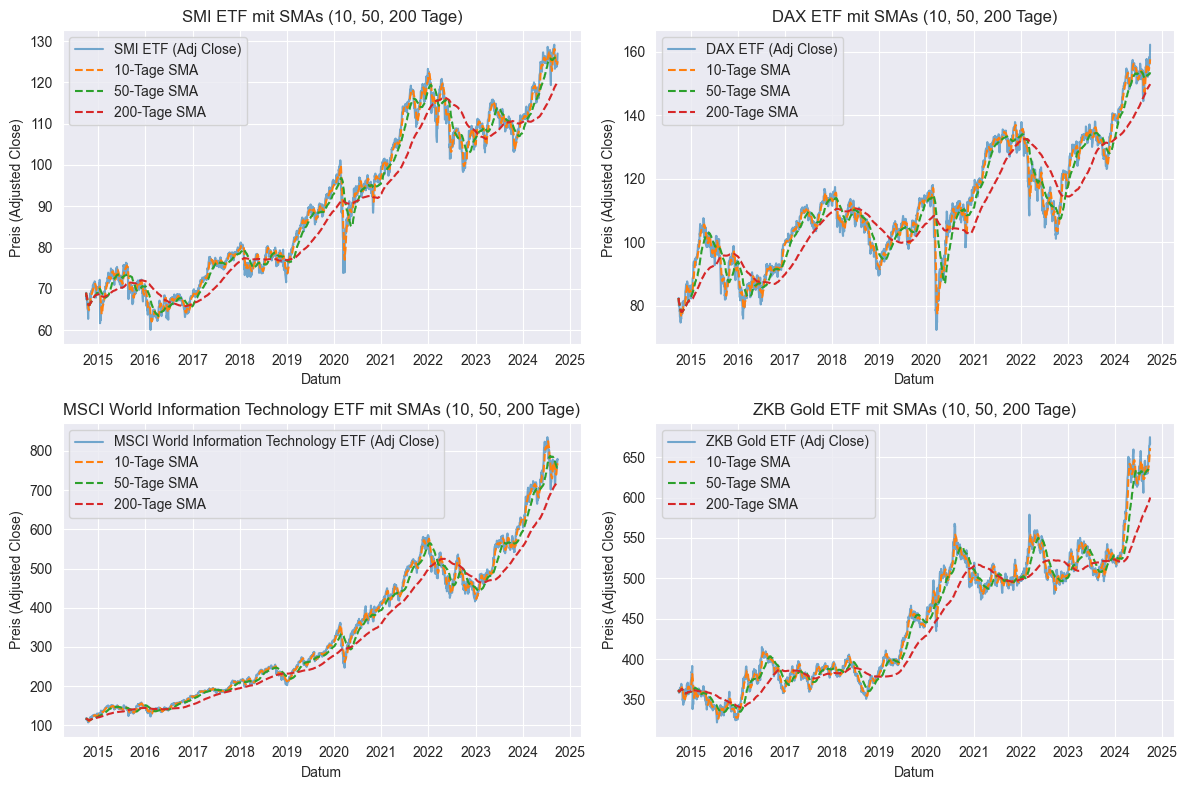

In [128]:
# Berechnung der Simple Moving Averages für 10, 50 und 200 Tage
sma_10 = index_data_etfs.rolling(window=10, min_periods=1).mean()
sma_50 = index_data_etfs.rolling(window=50, min_periods=1).mean()
sma_200 = index_data_etfs.rolling(window=200, min_periods=1).mean()

# Anzahl der ETFs und die Aufteilung auf zwei Reihen berechnen
num_etfs = len(etfs)
rows = math.ceil(num_etfs / 2)
cols = 2

# Subplots erstellen
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

# Falls es eine ungerade Anzahl an ETFs gibt, kann eine leere Achse erscheinen. Diese verstecken wir dann später.
axes = axes.flatten()

# Plots in den Subplots erzeugen
for idx, name in enumerate(etfs):
    axes[idx].plot(index_data_etfs[name], label=f"{name} (Adj Close)", alpha=0.6)
    axes[idx].plot(sma_10[name], label="10-Tage SMA", linestyle='--')
    axes[idx].plot(sma_50[name], label="50-Tage SMA", linestyle='--')
    axes[idx].plot(sma_200[name], label="200-Tage SMA", linestyle='--')
    axes[idx].set_title(f"{name} mit SMAs (10, 50, 200 Tage)")
    axes[idx].set_xlabel("Datum")
    axes[idx].set_ylabel("Preis (Adjusted Close)")
    axes[idx].legend(loc="upper left")
    axes[idx].grid(True)

# Falls es leere Subplots gibt, diese verstecken
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Zusammenfassen der SMAs in einem DataFrame für den Export
sma_table = pd.concat([index_data_etfs, sma_10, sma_50, sma_200], axis=1,
                      keys=['Adjusted Close', 'SMA_10', 'SMA_50', 'SMA_200'])

# Linear Weighted Moving Average

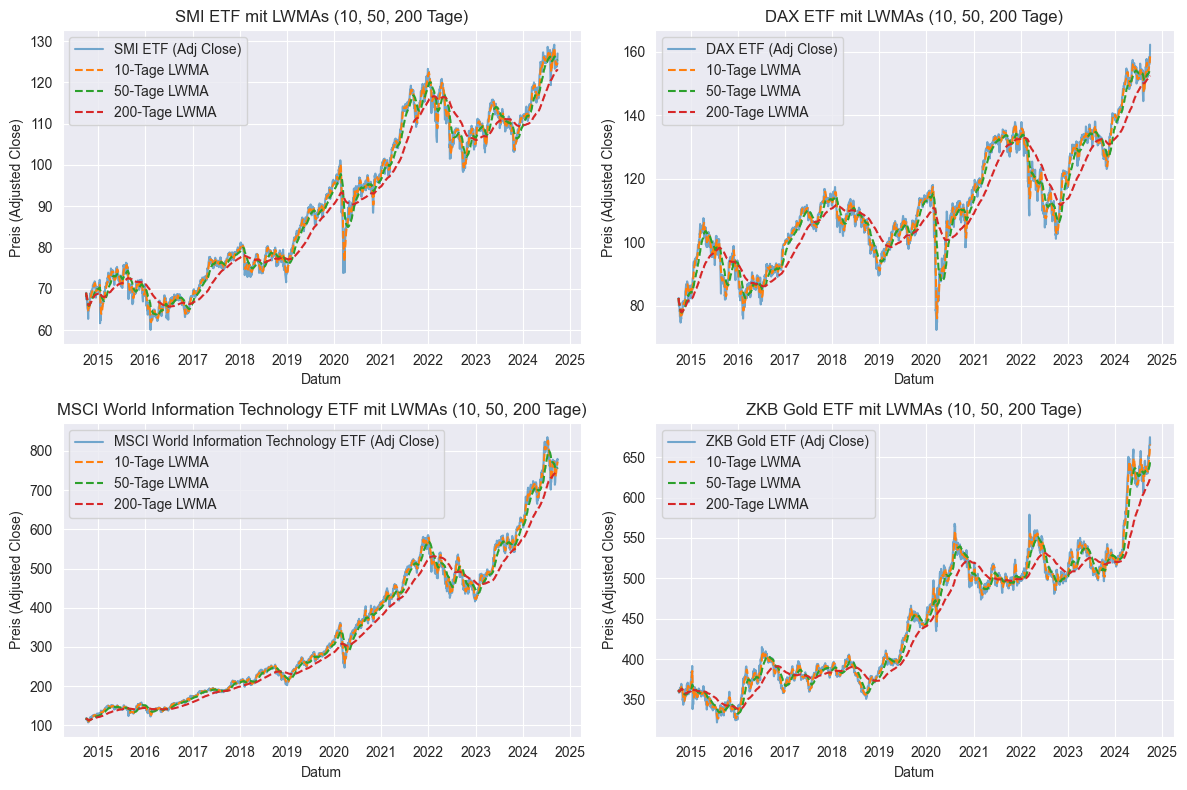

In [129]:
def lwma(data, window_size):
    """
    Berechnet den Linear Weighted Moving Average (LWMA) für eine gegebene Datenreihe und Fenstergröße.

    :param data: Pandas Series oder Liste
    :param window_size: Die Größe des Fensters für die Berechnung des LWMA
    :return: Pandas Series mit den LWMA-Werten
    """
    weights = np.arange(1, window_size + 1)
    lwma = data.rolling(window=window_size, min_periods=1).apply(
        lambda prices: np.dot(prices, weights[-len(prices):]) / weights[-len(prices):].sum(),
        raw=True
    )
    return lwma

# Berechnung der Linear Weighted Moving Averages für 10, 50 und 200 Tage
lwma_10 = lwma(index_data_etfs, 10)
lwma_50 = lwma(index_data_etfs, 50)
lwma_200 = lwma(index_data_etfs, 200)

# Anzahl der ETFs und die Aufteilung auf zwei Reihen berechnen
num_etfs = len(etfs)
rows = math.ceil(num_etfs / 2)
cols = 2

# Subplots erstellen
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

# Falls es eine ungerade Anzahl an ETFs gibt, kann eine leere Achse erscheinen. Diese verstecken wir dann später.
axes = axes.flatten()

# Plots in den Subplots erzeugen
for idx, name in enumerate(etfs):
    axes[idx].plot(index_data_etfs[name], label=f"{name} (Adj Close)", alpha=0.6)
    axes[idx].plot(lwma_10[name], label="10-Tage LWMA", linestyle='--')
    axes[idx].plot(lwma_50[name], label="50-Tage LWMA", linestyle='--')
    axes[idx].plot(lwma_200[name], label="200-Tage LWMA", linestyle='--')
    axes[idx].set_title(f"{name} mit LWMAs (10, 50, 200 Tage)")
    axes[idx].set_xlabel("Datum")
    axes[idx].set_ylabel("Preis (Adjusted Close)")
    axes[idx].legend(loc="upper left")
    axes[idx].grid(True)

# Falls es leere Subplots gibt, diese verstecken
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Zusammenfassen der LWMAs in einem DataFrame
lwma_table = pd.concat([lwma_10, lwma_50, lwma_200], axis=1, keys=['LWMA_10', 'LWMA_50', 'LWMA_200'])

# Exponential Weighted Moving Averaged

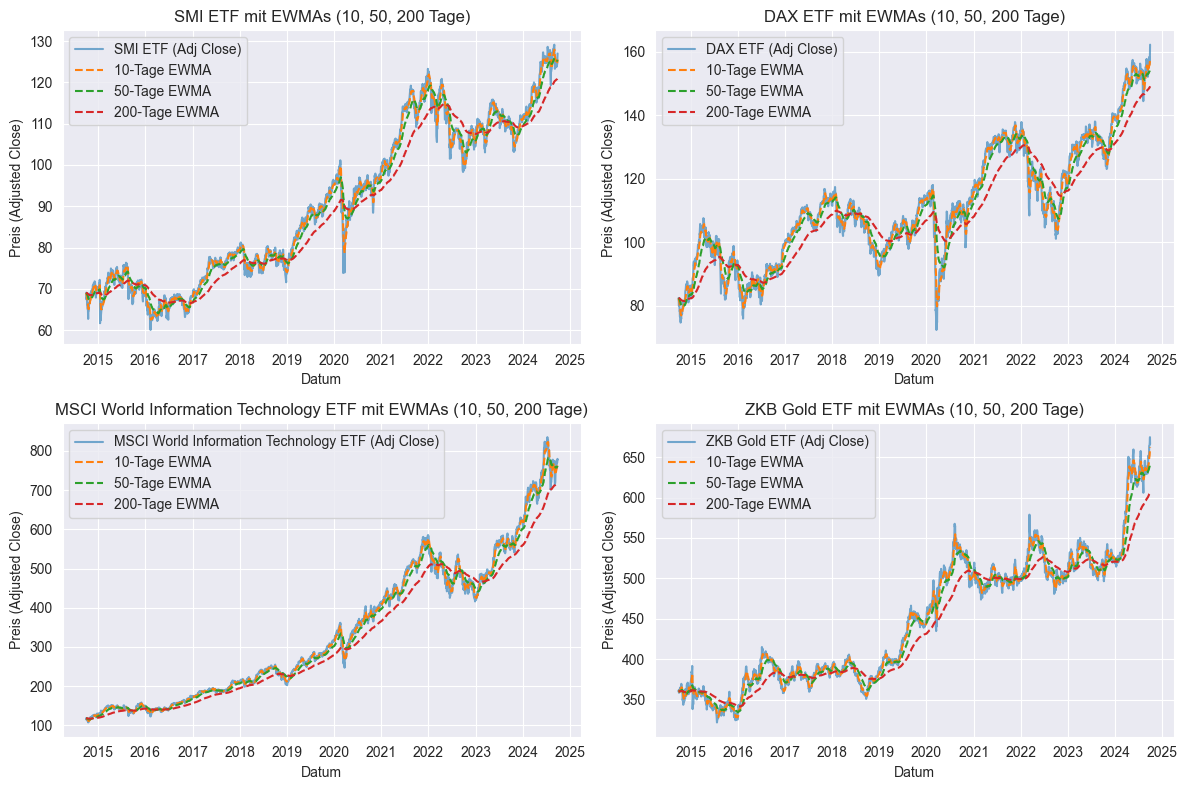

In [130]:
# Berechnung der Exponential Weighted Moving Averages für 10, 50 und 200 Tage
ewma_10 = index_data_etfs.ewm(span=10, adjust=False).mean()
ewma_50 = index_data_etfs.ewm(span=50, adjust=False).mean()
ewma_200 = index_data_etfs.ewm(span=200, adjust=False).mean()

# Anzahl der ETFs und die Aufteilung auf zwei Reihen berechnen
num_etfs = len(etfs)
rows = math.ceil(num_etfs / 2)
cols = 2

# Subplots erstellen
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

# Falls es eine ungerade Anzahl an ETFs gibt, kann eine leere Achse erscheinen. Diese verstecken wir dann später.
axes = axes.flatten()

# Plots in den Subplots erzeugen
for idx, name in enumerate(etfs):
    axes[idx].plot(index_data_etfs[name], label=f"{name} (Adj Close)", alpha=0.6)
    axes[idx].plot(ewma_10[name], label="10-Tage EWMA", linestyle='--')
    axes[idx].plot(ewma_50[name], label="50-Tage EWMA", linestyle='--')
    axes[idx].plot(ewma_200[name], label="200-Tage EWMA", linestyle='--')
    axes[idx].set_title(f"{name} mit EWMAs (10, 50, 200 Tage)")
    axes[idx].set_xlabel("Datum")
    axes[idx].set_ylabel("Preis (Adjusted Close)")
    axes[idx].legend(loc="upper left")
    axes[idx].grid(True)

# Falls es leere Subplots gibt, diese verstecken
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Zusammenfassen der EWMAs in einem DataFrame
ewma_table = pd.concat([ewma_10, ewma_50, ewma_200], axis=1, keys=['EWMA_10', 'EWMA_50', 'EWMA_200'])

# Moving Average Crossover

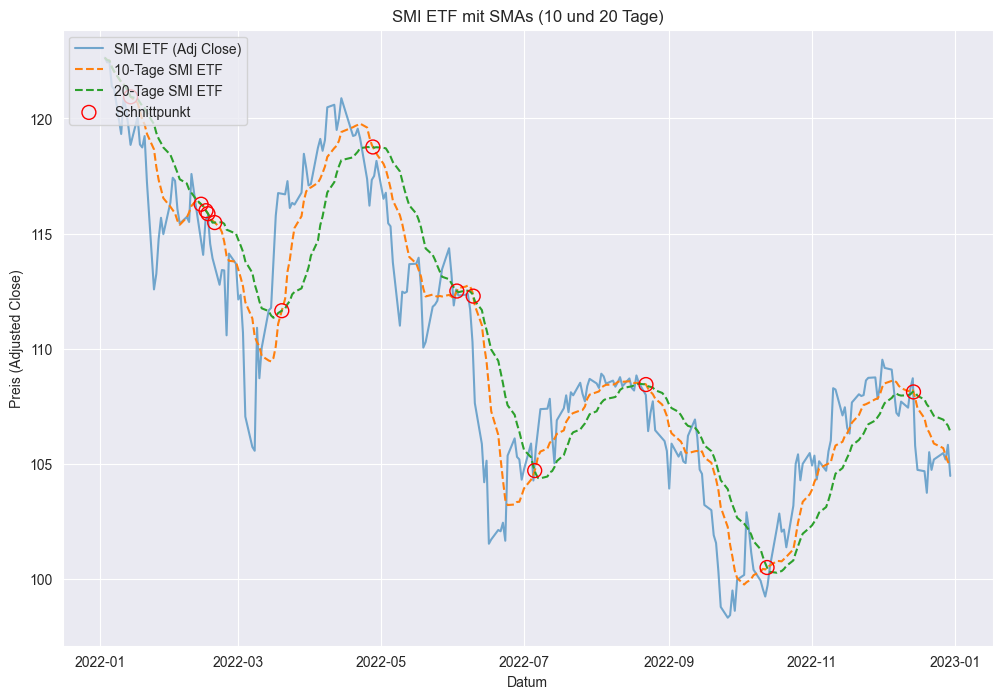

In [131]:
# Zeitraum definieren
start_date = '2022-01-01'
end_date = '2023-01-01'

# Berechnung der Simple Moving Averages für 10 und 20 Tage
sma_10_period = index_data_etfs["SMI ETF"].loc[start_date:end_date].rolling(window=10, min_periods=1).mean()
sma_20_period = index_data_etfs["SMI ETF"].loc[start_date:end_date].rolling(window=20, min_periods=1).mean()


# Berechnung der Schnittpunkte: Unterschiede zwischen SMA10 und SMA20
difference = sma_10_period - sma_20_period

# Schnittpunkte finden: Wenn der Unterschied die Richtung wechselt (Vorzeichenänderung)
crossing_points = np.where(np.diff(np.sign(difference)))[0]

plt.figure(figsize=(12, 8))
plt.plot(index_data_etfs["SMI ETF"].loc[start_date:end_date], label="SMI ETF (Adj Close)", alpha=0.6)
plt.plot(sma_10_period, label="10-Tage SMI ETF", linestyle='--')
plt.plot(sma_20_period, label="20-Tage SMI ETF", linestyle='--')

# Kreise an den Schnittpunkten zeichnen
for idx in crossing_points:
    # Datum vor und nach dem Schnittpunkt bestimmen
    date_before = sma_10_period.index[idx]
    date_after = sma_10_period.index[idx + 1]

    # Werte vor und nach dem Schnittpunkt bestimmen
    value_before = sma_10_period.iloc[idx]
    value_after = sma_10_period.iloc[idx + 1]

    # Interpolation der Schnittstelle zwischen den beiden Punkten
    diff_before = difference.iloc[idx]
    diff_after = difference.iloc[idx + 1]

    # Berechne den genauen Schnittpunkt durch lineare Interpolation
    crossing_date = date_before + (date_after - date_before) * (0 - diff_before) / (diff_after - diff_before)
    crossing_value = value_before + (value_after - value_before) * (0 - diff_before) / (diff_after - diff_before)

    # Kreise an den interpolierten Schnittpunkten zeichnen
    plt.scatter(crossing_date, crossing_value, color='none', s=100, edgecolor='red', zorder=5, label="Schnittpunkt" if idx == crossing_points[0] else "")

plt.title("SMI ETF mit SMAs (10 und 20 Tage)")
plt.xlabel("Datum")
plt.ylabel("Preis (Adjusted Close)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Moving Average Crossover Divergence

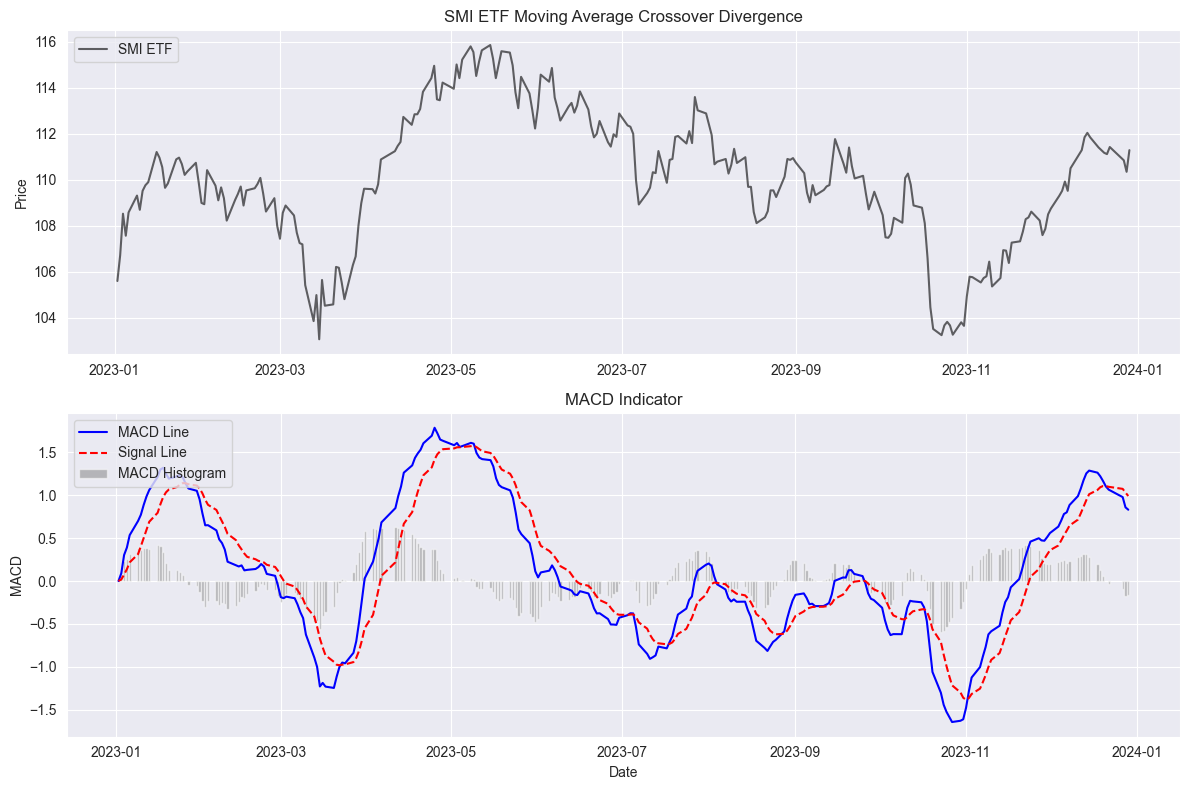

In [132]:
# Zeitraum definieren
start_date = '2023-01-01'
end_date = '2024-01-01'

# Berechnung des MACD
short_window = 12
long_window = 26
signal_window = 9

# Exponentielle gleitende Durchschnitte berechnen
ema_12 = index_data_etfs["SMI ETF"].loc[start_date:end_date].ewm(span=short_window, adjust=False).mean()
ema_26 = index_data_etfs["SMI ETF"].loc[start_date:end_date].ewm(span=long_window, adjust=False).mean()

# MACD Line berechnen
macd_line = ema_12 - ema_26

# Signal Line berechnen
signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

# MACD Histogram berechnen
macd_histogram = macd_line - signal_line

# Plot erstellen
plt.figure(figsize=(12, 8))

# Preisdiagramm (oben)
plt.subplot(2, 1, 1)  # 2 Zeilen, 1 Spalte, 1. Position
plt.plot(index_data_etfs["SMI ETF"].loc[start_date:end_date], label='SMI ETF', color='black', alpha=0.6)
plt.title('SMI ETF Moving Average Crossover Divergence')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# MACD-Diagramm (unten)
plt.subplot(2, 1, 2)  # 2 Zeilen, 1 Spalte, 2. Position
plt.plot(macd_line, label='MACD Line', color='blue', linewidth=1.5)
plt.plot(signal_line, label='Signal Line', color='red', linewidth=1.5, linestyle='--')

# Histogram als Balkendiagramm
plt.bar(macd_histogram.index, macd_histogram, label='MACD Histogram', color='gray', alpha=0.5)

# Titel und Legenden
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend(loc='upper left')
plt.grid(True)

# Layout-Anpassungen
plt.tight_layout()
plt.show()


Der obere Graph zeigt den Kursverlauf vom DAX an. Im unteren Teil ist die MACD Linie sowie die Singallinie sichtbar. Liegt der MACD-Wert über null, liegt der kurzfristige gleitende Durchschnitt über dem langfristigen, was einen Aufwärtstrend signalisiert. Das Gegenteil ist der Fall, wenn der Wert unter null liegt. Kreuzen sich MACD- und Signallinie, kann das ein Kauf- resp. Verkaufssignal sein. Das Histogramm zeigt zudem an, ob sich der Trend beschleunigt. Ein grösseres Histogramm deutet darauf hin, dass der Trend stärker wird und umgekehrt. 

# Bollinger Bands

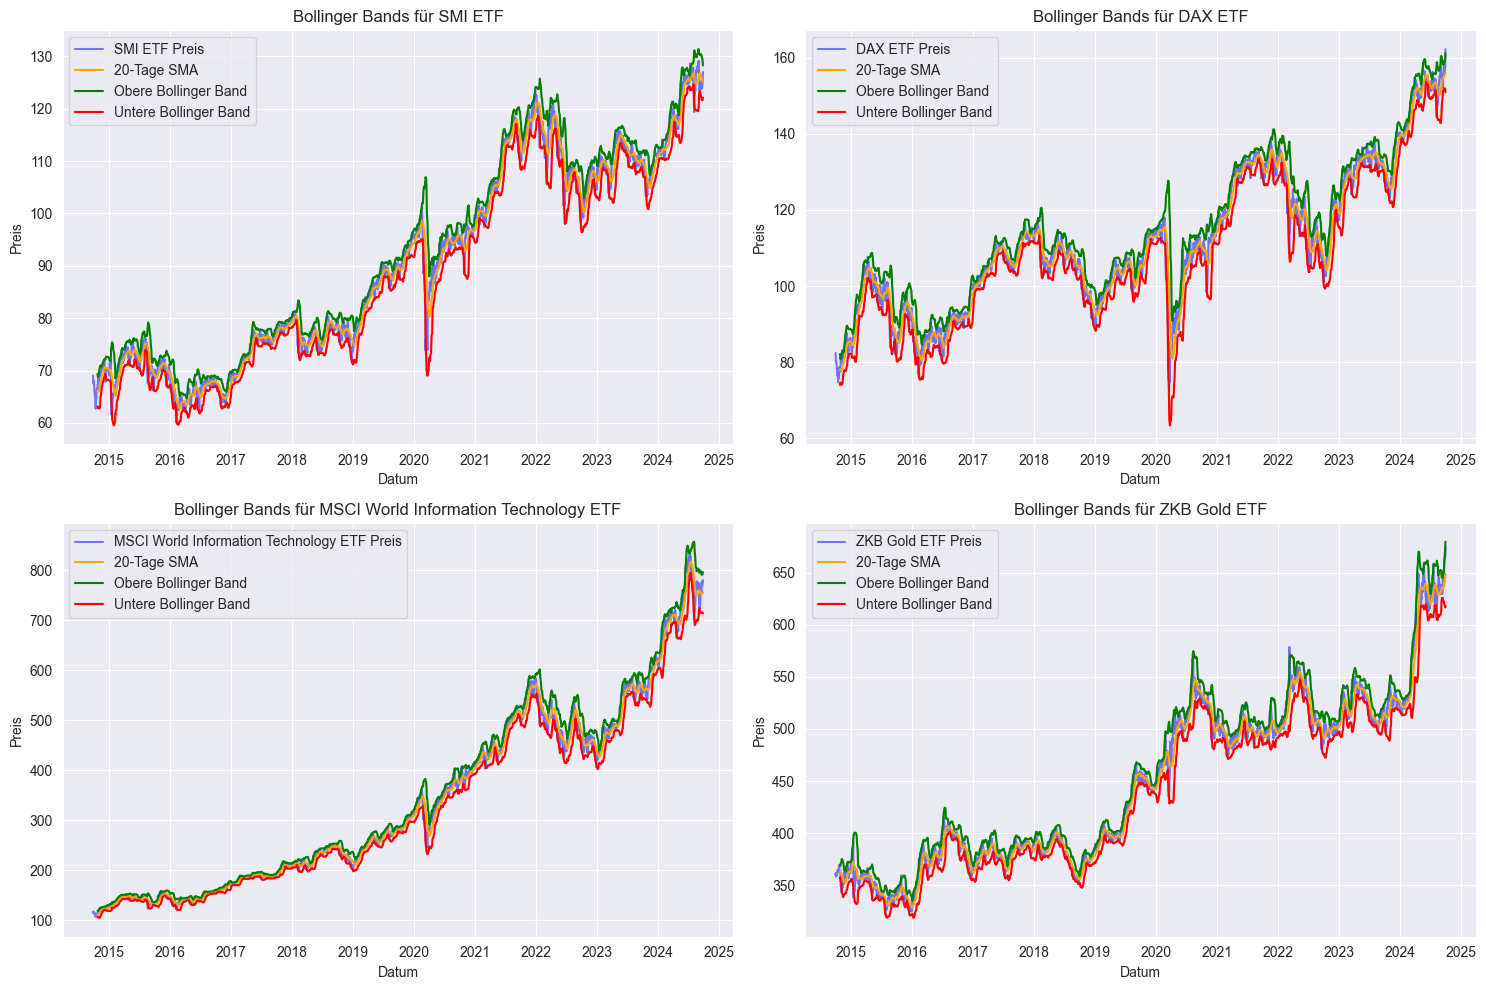

In [133]:
# Berechnung der Bollinger Bands (20 Tage) für die interpolierten Daten
bb_window = 20
num_etfs = len(index_data_etfs.columns)
rows = math.ceil(num_etfs / 2)  # Anzahl der Zeilen, basierend auf 2 Spalten

fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))  # Raster mit 2 Kolonnen
axes = axes.flatten()  # Flachstellen, um einfacher darauf zuzugreifen

for i, etf in enumerate(index_data_etfs.columns):
    # 20-Tage-SMA
    sma = index_data_etfs[etf].rolling(window=bb_window).mean()

    # Standardabweichung (20 Tage)
    std = index_data_etfs[etf].rolling(window=bb_window).std()

    # Obere und untere Bollinger Bänder
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)

    # Plot des ETFs mit den Bollinger Bändern
    ax = axes[i]
    ax.plot(index_data_etfs[etf], label=f'{etf} Preis', color='blue', alpha=0.5)
    ax.plot(sma, label='20-Tage SMA', color='orange')
    ax.plot(upper_band, label='Obere Bollinger Band', color='green')
    ax.plot(lower_band, label='Untere Bollinger Band', color='red')
    ax.fill_between(index_data_etfs.index, lower_band, upper_band, color='lightgray', alpha=0.3)
    ax.set_title(f'Bollinger Bands für {etf}')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Preis')
    ax.legend(loc='upper left')
    ax.grid(True)

# Entfernen ungenutzter Subplots, falls ETFs < Anzahl Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Momentum

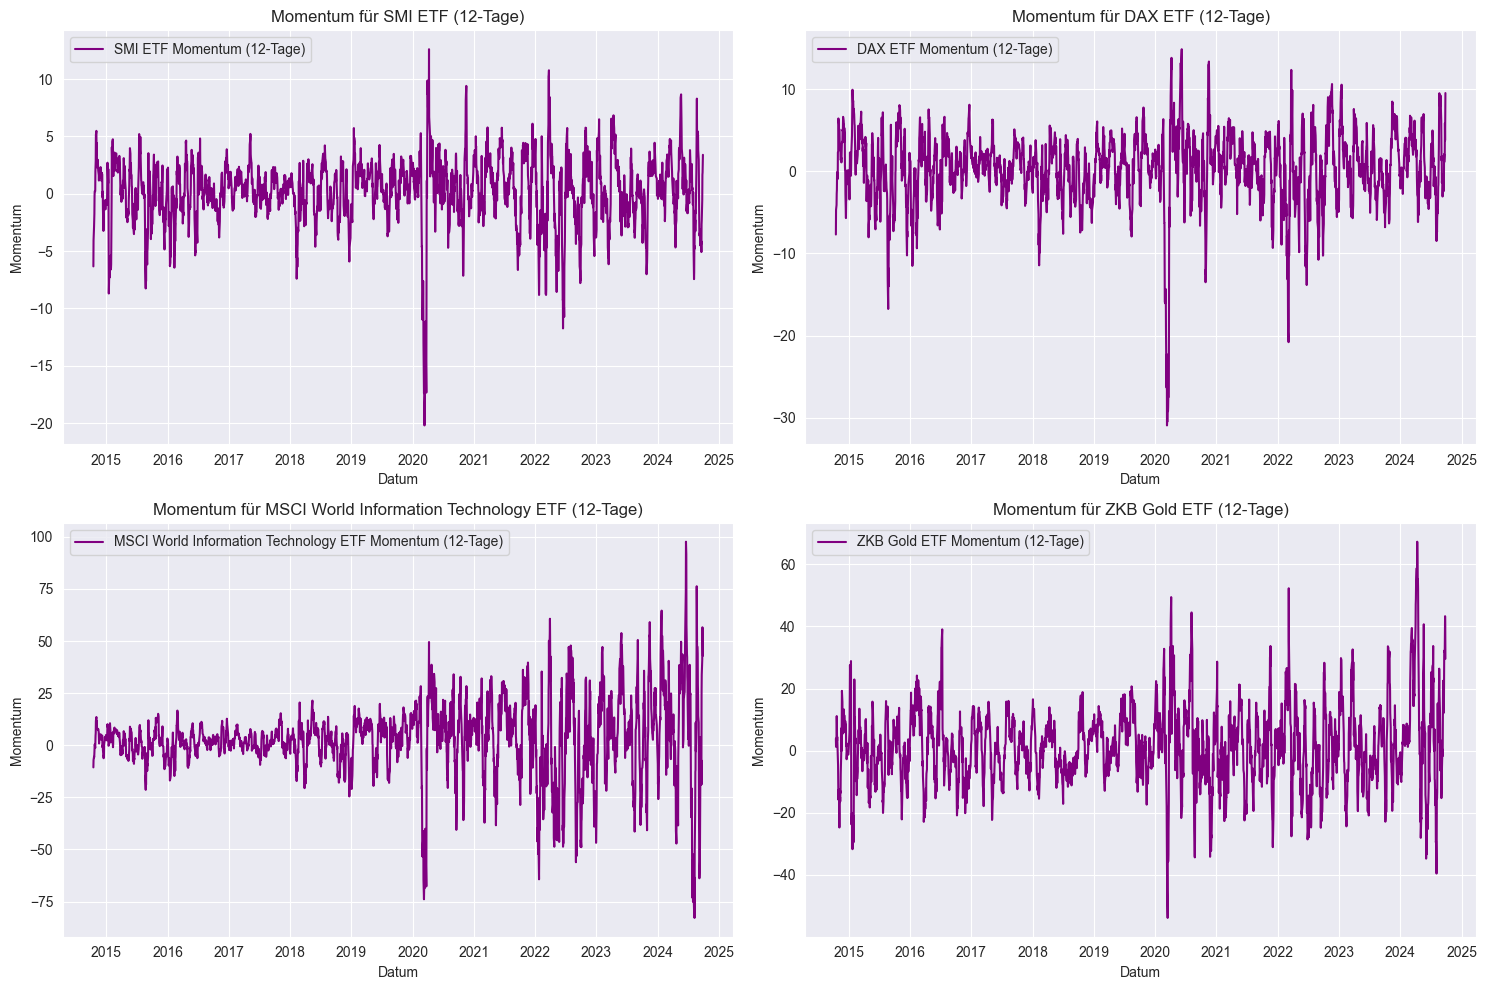

In [134]:
# Momentum-Berechnung
momentum_window = 12
momentum = index_data_etfs.diff(periods=momentum_window)

# Anzahl der ETFs und Zeilen im Raster
num_etfs = len(index_data_etfs.columns)
rows = math.ceil(num_etfs / 2)  # Anzahl der Zeilen, basierend auf 2 Spalten

# Raster mit 2 Kolonnen erstellen
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))  # Größe des Rasters
axes = axes.flatten()  # Flachstellen für einfacheren Zugriff

for i, etf in enumerate(index_data_etfs.columns):
    ax = axes[i]
    ax.plot(momentum[etf], label=f'{etf} Momentum ({momentum_window}-Tage)', color='purple')
    ax.set_title(f'Momentum für {etf} ({momentum_window}-Tage)')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Momentum')
    ax.legend(loc='upper left')
    ax.grid(True)

# Entfernen ungenutzter Subplots, falls ETFs < Anzahl Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Optimierung der Layouts
plt.show()

# Price Rate-of-Change

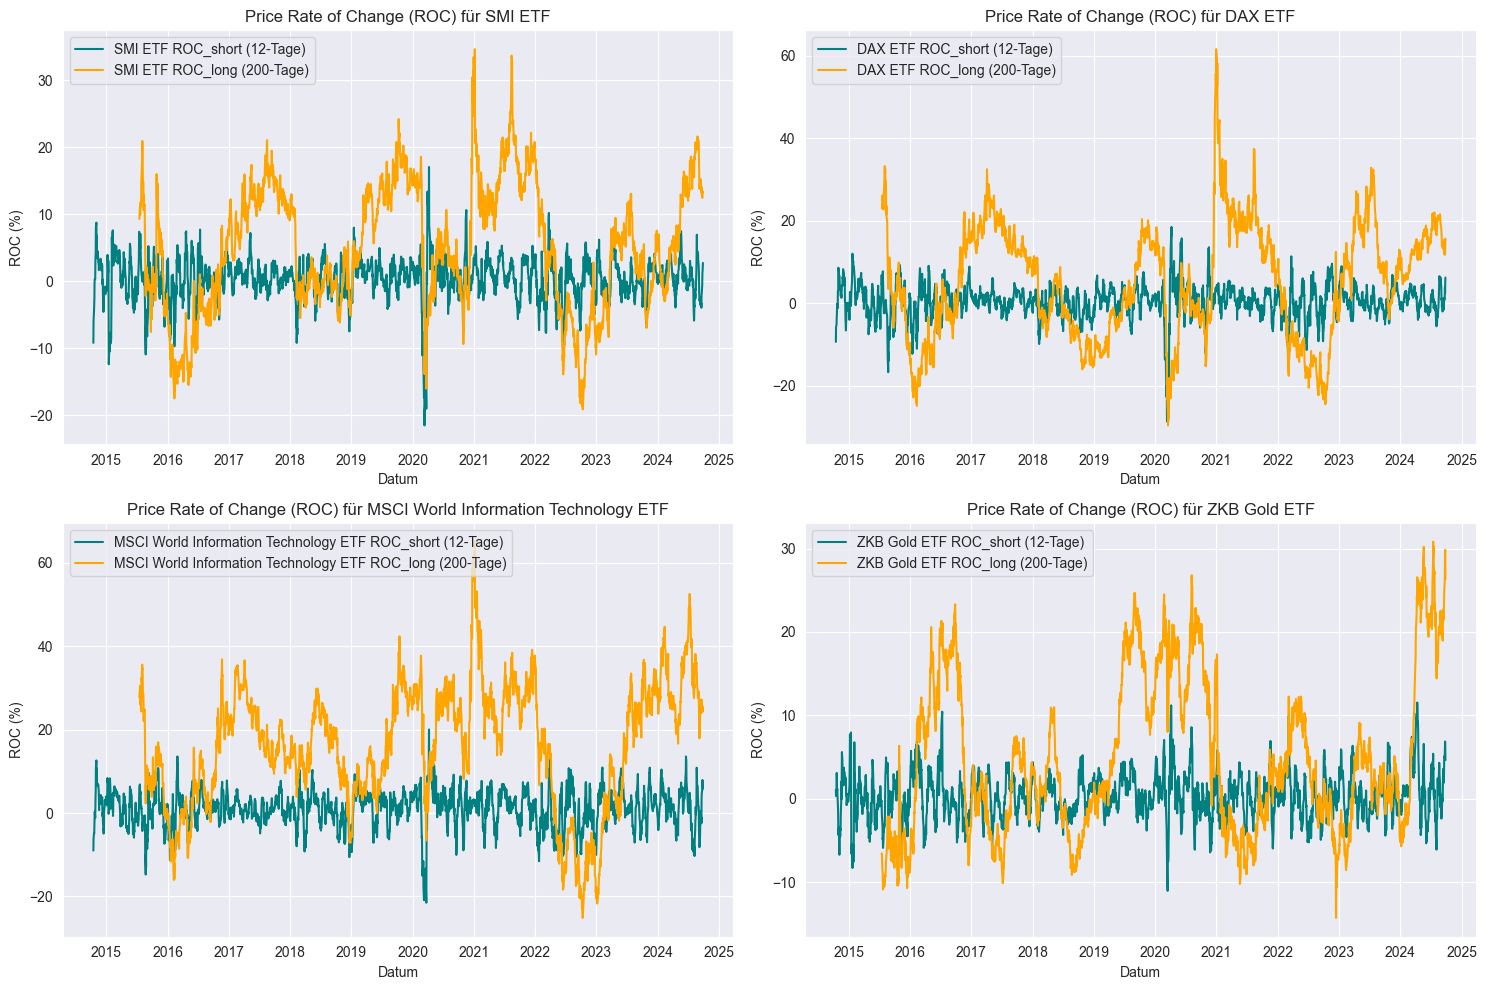

In [135]:
# Zeitfenster für die Berechnung des ROC
roc_short_window = 12  # Kurzfristig
roc_long_window = 200  # Langfristig

# Berechnung des ROC für alle ETFs (Kurzfristig und Langfristig)
roc_short = ((index_data_etfs / index_data_etfs.shift(periods=roc_short_window)) - 1) * 100
roc_long = ((index_data_etfs / index_data_etfs.shift(periods=roc_long_window)) - 1) * 100

# Anzahl der ETFs und Zeilen im Raster
num_etfs = len(index_data_etfs.columns)
rows = math.ceil(num_etfs / 2)  # Anzahl der Zeilen, basierend auf 2 Spalten

# Raster mit 2 Kolonnen erstellen
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))  # Größe des Rasters
axes = axes.flatten()  # Flachstellen für einfacheren Zugriff

for i, etf in enumerate(index_data_etfs.columns):
    ax = axes[i]

    # Plot ROC_short (12 Tage)
    ax.plot(roc_short[etf], label=f'{etf} ROC_short ({roc_short_window}-Tage)', color='teal')

    # Plot ROC_long (200 Tage)
    ax.plot(roc_long[etf], label=f'{etf} ROC_long ({roc_long_window}-Tage)', color='orange')

    ax.set_title(f'Price Rate of Change (ROC) für {etf}')
    ax.set_xlabel('Datum')
    ax.set_ylabel('ROC (%)')
    ax.legend(loc='upper left')
    ax.grid(True)

# Entfernen ungenutzter Subplots, falls ETFs < Anzahl Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Optimierung der Layouts
plt.show()

# Highest Highs und Lowest Lows pro Quartal

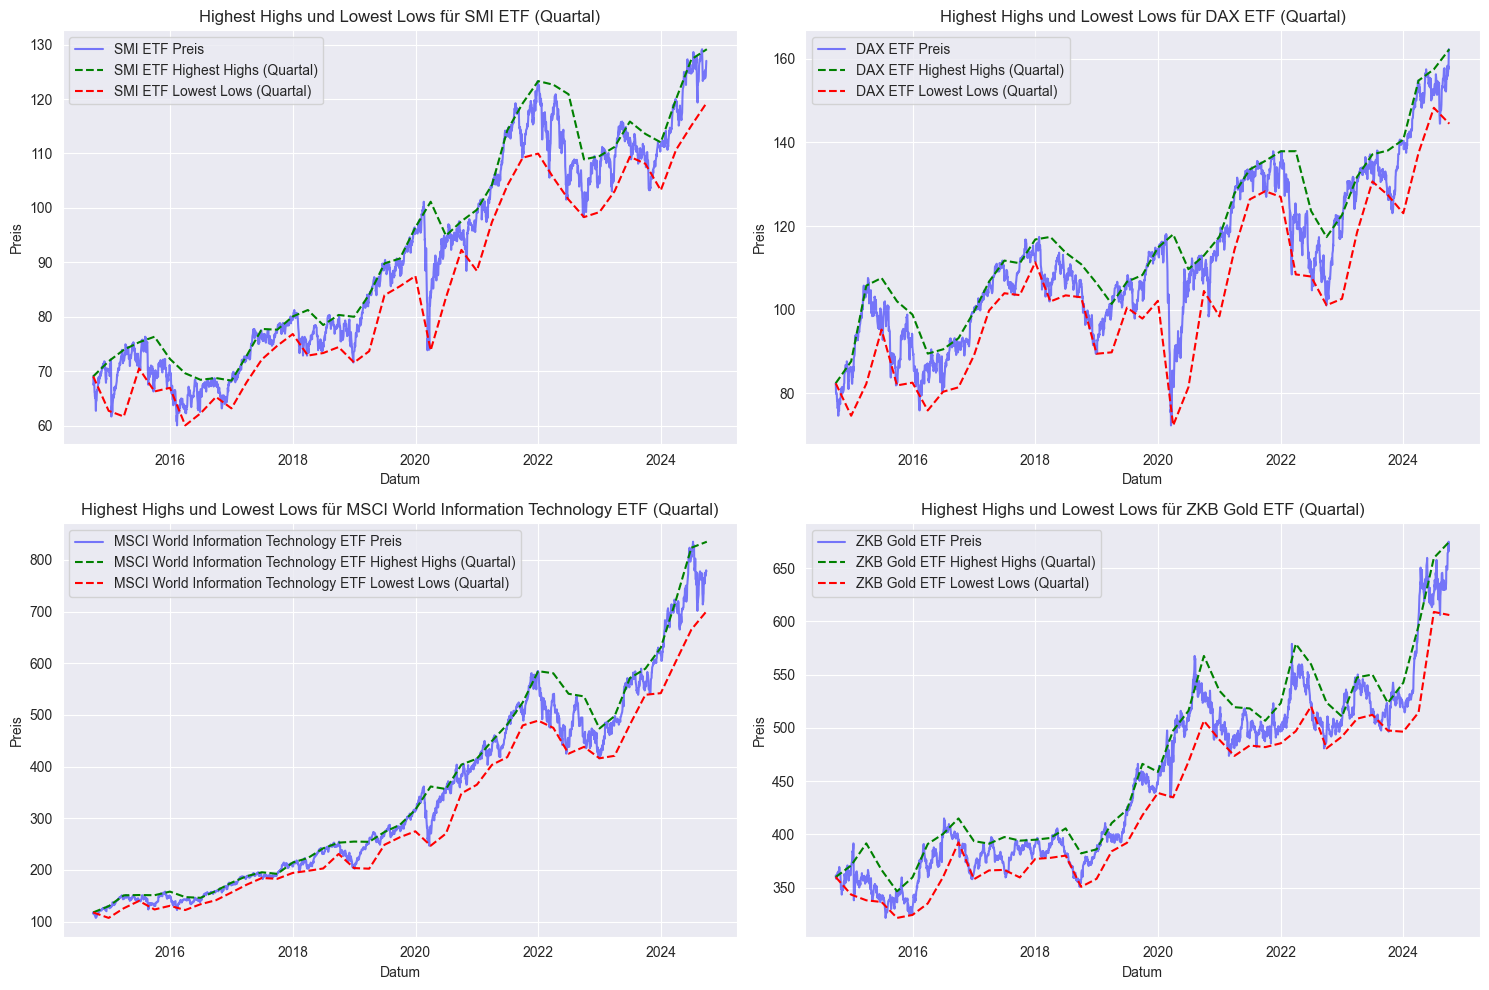

In [136]:
# Berechnung der Highest Highs und Lowest Lows für jedes Quartal
highest_highs = index_data_etfs.resample('QE').max()  # Höchste Preise pro Quartal
lowest_lows = index_data_etfs.resample('QE').min()    # Niedrigste Preise pro Quartal

# Anzahl der ETFs und Zeilen im Raster
num_etfs = len(index_data_etfs.columns)
rows = math.ceil(num_etfs / 2)  # Anzahl der Zeilen, basierend auf 2 Spalten

# Raster mit 2 Kolonnen erstellen
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))  # Größe des Rasters
axes = axes.flatten()  # Flachstellen für einfacheren Zugriff

for i, etf in enumerate(index_data_etfs.columns):
    ax = axes[i]

    # Plot der Kursdaten
    ax.plot(index_data_etfs[etf], label=f'{etf} Preis', color='blue', alpha=0.5)

    # Plot der Highest Highs
    ax.plot(highest_highs[etf], label=f'{etf} Highest Highs (Quartal)', color='green', linestyle='--')

    # Plot der Lowest Lows
    ax.plot(lowest_lows[etf], label=f'{etf} Lowest Lows (Quartal)', color='red', linestyle='--')

    ax.set_title(f'Highest Highs und Lowest Lows für {etf} (Quartal)')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Preis')
    ax.legend(loc='upper left')
    ax.grid(True)

# Entfernen ungenutzter Subplots, falls ETFs < Anzahl Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Optimierung der Layouts
plt.show()
